**Loading Necessary Libraries**

In [13]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# KaggleHub for dataset
import kagglehub
from kagglehub import KaggleDatasetAdapter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import to_categorical

# Utilities
import os, cv2
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay

**Downloading the Dataset**

In [3]:
# Download dataset and get root path
dataset_root = kagglehub.dataset_download("dhruvildave/english-handwritten-characters-dataset")
print("Dataset root:", dataset_root)

# Load dataset as pandas dataframe
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "dhruvildave/english-handwritten-characters-dataset",
    "english.csv"  # the csv file inside the dataset
)

print("Dataset shape:", df.shape)
print(df.head())

# Prepend dataset_root to image paths
df["image"] = df["image"].apply(lambda x: os.path.join(dataset_root, x))


100%|██████████| 13.1M/13.1M [00:00<00:00, 144MB/s]

Extracting files...


Dataset root: /root/.cache/kagglehub/datasets/dhruvildave/english-handwritten-characters-dataset/versions/3
Download already complete (71622 bytes).
Dataset shape: (3410, 2)
                image label
0  Img/img001-001.png     0
1  Img/img001-002.png     0
2  Img/img001-003.png     0
3  Img/img001-004.png     0
4  Img/img001-005.png     0


**Resizing all the images**

In [4]:
IMG_SIZE = 32
images, labels = [], []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(dataset_root, row["image"])
    label = row["label"]

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Could not load:", img_path)
        continue
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    images.append(img.flatten())
    labels.append(str(label))

X = np.array(images, dtype=np.float32) / 255.0
y = np.array(labels)

print("X shape:", X.shape)
print("y shape:", y.shape)


100%|██████████| 3410/3410 [00:44<00:00, 76.02it/s]

X shape: (3410, 1024)
y shape: (3410,)


**Train Test Split**

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


**Perceptron Learning Algorithm**

In [6]:
class Perceptron:
    """
    Vectorized Perceptron with batch update per epoch:
      w <- w + lr * X.T @ (y - y_hat)
    This converges similarly to the incremental perceptron but is much faster in numpy.
    """
    def __init__(self, input_dim, lr=0.01, epochs=10, shuffle=True):
        self.w = np.zeros(input_dim, dtype=np.float32)
        self.b = 0.0
        self.lr = lr
        self.epochs = epochs
        self.shuffle = shuffle

    def step(self, z):
        return (z >= 0).astype(np.int32)

    def train(self, X, y):
        """
        X: (n_samples, n_features)
        y: (n_samples,) with values {0,1}
        """
        X = X.astype(np.float32)
        y = y.astype(np.int32)

        n = X.shape[0]
        for epoch in range(self.epochs):
            if self.shuffle:
                idx = np.random.permutation(n)
                X_epoch = X[idx]
                y_epoch = y[idx]
            else:
                X_epoch = X
                y_epoch = y

            # compute predictions for epoch
            z = X_epoch.dot(self.w) + self.b  # shape (n,)
            y_hat = self.step(z)              # shape (n,)

            # vectorized update: sum over all (target - pred) * x_i
            update_vec = (y_epoch - y_hat).astype(np.float32)  # shape (n,)
            # If no errors, update_vec is all zeros -> no change
            if np.any(update_vec != 0):
                self.w += self.lr * (X_epoch.T @ update_vec)
                self.b += self.lr * update_vec.sum()

    def predict(self, X):
        """
        Works for single sample (1D) or batch (2D).
        Returns 0/1 labels.
        """
        X = np.atleast_2d(X).astype(np.float32)
        z = X.dot(self.w) + self.b
        return (z >= 0).astype(np.int32).reshape(-1)


In [7]:
class PLAOvR:
    """
    One-vs-rest PLA. Uses vectorized Perceptron for speed.
    """
    def __init__(self, classes, input_dim, lr=0.01, epochs=10, shuffle=True):
        self.classes = np.array(classes)
        self.models = {c: Perceptron(input_dim, lr, epochs, shuffle) for c in self.classes}

    def fit(self, X, y):
        """
        X: (n_samples, n_features)
        y: (n_samples,) original labels (strings or ints)
        """
        for c in self.classes:
            # binary labels for this class
            y_binary = np.where(y == c, 1, 0)
            print(f"Training perceptron for class {c} (positive samples: {y_binary.sum()}/{len(y_binary)})")
            self.models[c].train(X, y_binary)

    def predict_scores(self, X):
        """
        Return scores for each class (matrix shape: n_samples x n_classes)
        score = w^T x + b
        """
        X = np.atleast_2d(X).astype(np.float32)
        n = X.shape[0]
        scores = np.zeros((n, len(self.classes)), dtype=np.float32)
        for i, c in enumerate(self.classes):
            m = self.models[c]
            scores[:, i] = X.dot(m.w) + m.b
        return scores

    def predict(self, X):
        """
        Multiclass prediction: choose class with highest score.
        X can be single sample or batch.
        Returns array of predicted class labels (same dtype as self.classes).
        """
        X = np.atleast_2d(X).astype(np.float32)
        scores = self.predict_scores(X)  # shape (n_samples, n_classes)
        idx = np.argmax(scores, axis=1)
        return self.classes[idx]

    def predict_binary(self, X, target_class):
        """
        Return binary predictions (1 if predicted class == target_class else 0).
        """
        preds = self.predict(X)
        return np.where(preds == target_class, 1, 0)


**Training the perceptron**

In [8]:
# Train PLA over the FULL train set (warning: still heavy but vectorized now)
pla = PLAOvR(np.unique(y_train), X_train.shape[1], lr=0.0005, epochs=10, shuffle=True)
pla.fit(X_train, y_train)


Training perceptron for class 0 (positive samples: 44/2728)
Training perceptron for class 1 (positive samples: 44/2728)
Training perceptron for class 2 (positive samples: 44/2728)
Training perceptron for class 3 (positive samples: 44/2728)
Training perceptron for class 4 (positive samples: 44/2728)
Training perceptron for class 5 (positive samples: 44/2728)
Training perceptron for class 6 (positive samples: 44/2728)
Training perceptron for class 7 (positive samples: 44/2728)
Training perceptron for class 8 (positive samples: 44/2728)
Training perceptron for class 9 (positive samples: 44/2728)
Training perceptron for class A (positive samples: 44/2728)
Training perceptron for class B (positive samples: 44/2728)
Training perceptron for class C (positive samples: 44/2728)
Training perceptron for class D (positive samples: 44/2728)
Training perceptron for class E (positive samples: 44/2728)
Training perceptron for class F (positive samples: 44/2728)
Training perceptron for class G (positiv

PLA Classification Report (multiclass):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.09      0.09      0.09        11
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00        11
           A       0.00      0.00      0.00        11
           B       0.00      0.00      0.00        11
           C       0.00      0.00      0.00        11
           D       0.00      0.00      0.00        11
           E       0.00      0.00      0.00        11
           F       0.00      0.00      0.00        11
           G       0.00      0.00      0.

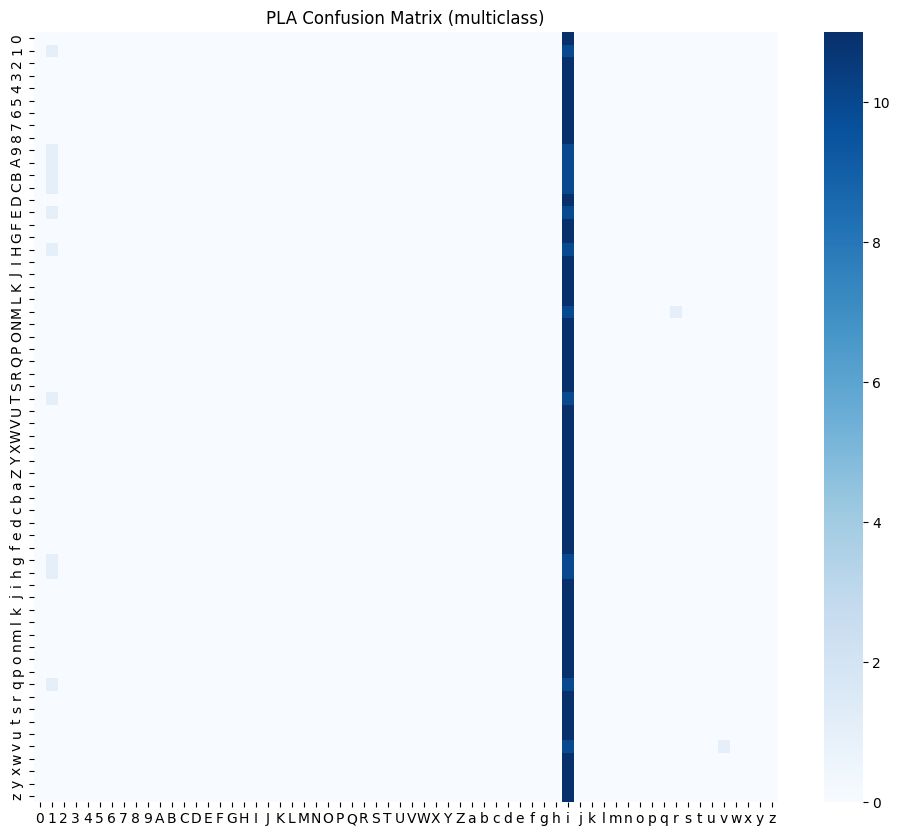


Confusion Matrix for class '1' (1 vs not-1):
 [[  1  10]
 [ 10 661]]

Binary classification report:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       671
       not 1       0.09      0.09      0.09        11

    accuracy                           0.97       682
   macro avg       0.54      0.54      0.54       682
weighted avg       0.97      0.97      0.97       682



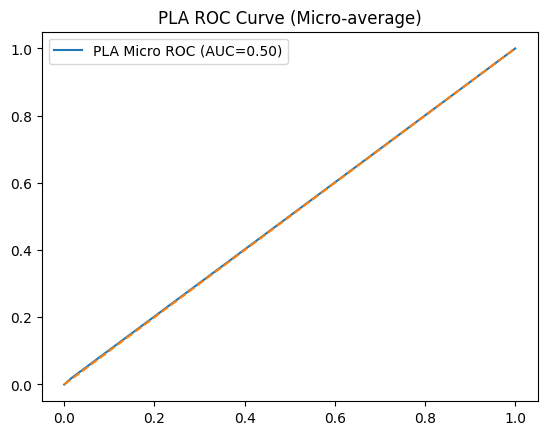

In [9]:
# ---------- PLA Evaluation ----------
y_pred_pla = pla.predict(X_test)   # vectorized prediction for full test set
print("PLA Classification Report (multiclass):")
print(classification_report(y_test, y_pred_pla, zero_division=0))

# Confusion Matrix (multiclass)
labels_sorted = np.unique(y)  # ensures consistent ordering
cm_pla = confusion_matrix(y_test, y_pred_pla, labels=labels_sorted)
plt.figure(figsize=(12,10))
sns.heatmap(cm_pla, cmap="Blues", xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.title("PLA Confusion Matrix (multiclass)")
plt.show()

# If you want a 1 vs not-1 confusion matrix for a specific target:
def evaluate_binary_class(pla_model, X_test, y_test, target_class):
    """
    y_test: original labels
    returns: confusion matrix (2x2), prints classification report
    """
    y_true_bin = np.where(y_test == target_class, 1, 0)
    y_pred_bin = pla_model.predict_binary(X_test, target_class)

    # Ensure confusion_matrix uses order [1, 0] -> rows: true 1, true 0
    cm = confusion_matrix(y_true_bin, y_pred_bin, labels=[1, 0])
    print(f"\nConfusion Matrix for class '{target_class}' (1 vs not-1):\n", cm)
    # classification_report expects labels 0/1; name them for clarity
    print("\nBinary classification report:")
    print(classification_report(y_true_bin, y_pred_bin, target_names=[f"{target_class}", f"not {target_class}"], zero_division=0))
    return cm

# Example: evaluate for class "1" (or whatever label string you use)
target = "1"
if target in np.unique(y):
    cm_1 = evaluate_binary_class(pla, X_test, y_test, target)
else:
    print(f"Target class '{target}' not found in labels. Available labels: {np.unique(y)[:10]} ...")

# ROC Curves (micro-average) for PLA (requires binarized labels)
lb_pla = LabelBinarizer().fit(y)  # fit on all labels to ensure consistent mapping
y_test_bin = lb_pla.transform(y_test)
y_pred_bin = lb_pla.transform(y_pred_pla)

# Flatten and compute micro AUC
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc_micro = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"PLA Micro ROC (AUC={roc_auc_micro:.2f})")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.title("PLA ROC Curve (Micro-average)")
plt.show()

**Multi Layer Perceptron**

In [14]:
# Reshape X for Keras (expects images with channel dimension)
X_train_reshaped = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test_reshaped = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Encode labels -> integers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# One-hot encode labels
y_train_cat = to_categorical(y_train_enc, num_classes=len(le.classes_))
y_test_cat = to_categorical(y_test_enc, num_classes=len(le.classes_))

print("X_train shape:", X_train_reshaped.shape)
print("y_train_cat shape:", y_train_cat.shape)

X_train shape: (2728, 32, 32, 1)
y_train_cat shape: (2728, 62)


In [ ]:
# Define MLP model
model = models.Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(le.classes_), activation="softmax")
])

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 672,062 (2.56 MB)

 Trainable params: 672,062 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(
    X_train_reshaped, y_train_cat,
    validation_data=(X_test_reshaped, y_test_cat),
    epochs=30,
    batch_size=128,
    verbose=1
)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.0154 - loss: 4.4303 - val_accuracy: 0.0176 - val_loss: 4.1368
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0210 - loss: 4.1646 - val_accuracy: 0.0117 - val_loss: 4.1274
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0217 - loss: 4.1384 - val_accuracy: 0.0235 - val_loss: 4.1246
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0154 - loss: 4.1366 - val_accuracy: 0.0279 - val_loss: 4.1247
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0186 - loss: 4.1261 - val_accuracy: 0.0337 - val_loss: 4.1181
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0187 - loss: 4.1201 - val_accuracy: 0.0293 - val_loss: 4.1128
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0139 - loss: 4.1186 - val_accuracy: 0.0308 - val_loss: 4.1042
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0304 - loss: 4.1066 - val_accuracy: 0.0469 - v

**Visualization**

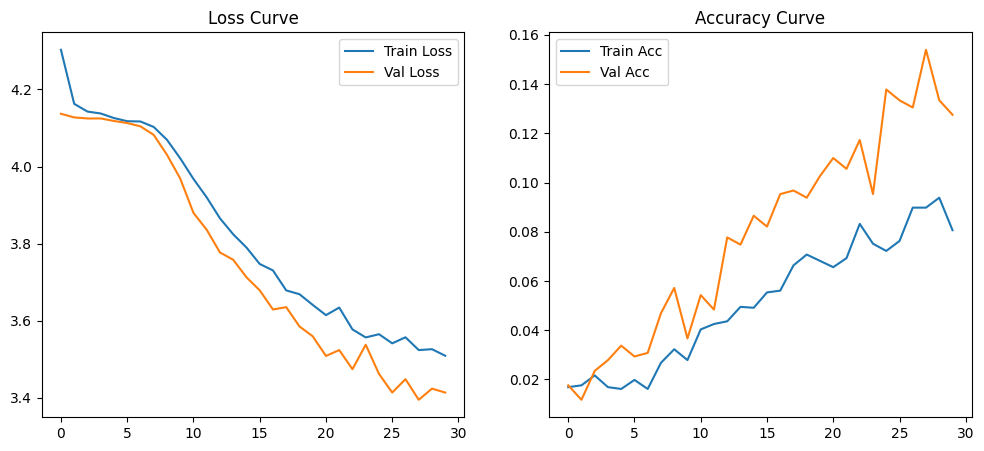

In [19]:
# Plot loss/accuracy curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy Curve")
plt.show()

In [20]:
#Evaluation
y_pred_prob = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)

print("MLP Classification Report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MLP Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        11
           2       1.00      0.09      0.17        11
           3       0.33      0.09      0.14        11
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00        11
           A       0.19      0.45      0.26        11
           B       0.20      0.09      0.12        11
           C       0.17      0.36      0.24        11
           D       0.27      0.36      0.31        11
           E       0.00      0.00      0.00        11
           F       0.04      0.09      0.06        11
           G   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


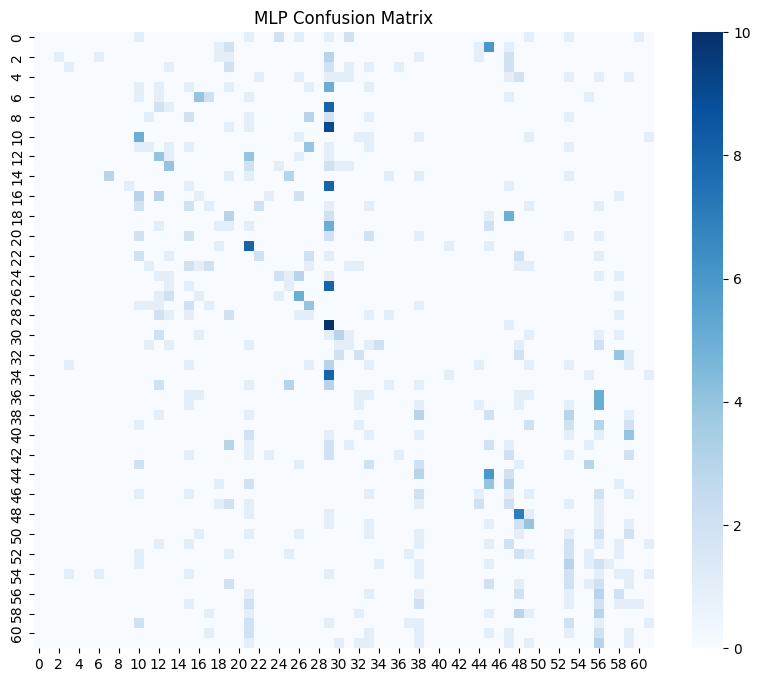

In [21]:
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues")
plt.title("MLP Confusion Matrix")
plt.show()

In [ ]:
#Function to build and train MLP with given config
def build_and_train_mlp(config, epochs=20):
    # Build model dynamically
    model = models.Sequential()
    model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(layers.Flatten())

    # Hidden layers
    for units in config["hidden_layers"]:
        model.add(layers.Dense(units, activation=config["activation"]))
        model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(len(le.classes_), activation="softmax"))

    # Optimizer
    if config["optimizer"] == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=config["lr"])
    elif config["optimizer"] == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=config["lr"], momentum=0.9)
    else:
        raise ValueError(f"Unknown optimizer: {config['optimizer']}")

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Train model
    history = model.fit(
        X_train_reshaped, y_train_cat,
        validation_data=(X_test_reshaped, y_test_cat),
        epochs=epochs,
        batch_size=config["batch_size"],
        verbose=0  # silent training
    )

    # Final validation accuracy
    val_acc = history.history["val_accuracy"][-1]
    return val_acc, history, model


**Hyperparameter Tuning**

In [24]:
param_grid = [
    {"hidden_layers": [128], "activation": "relu", "lr": 0.001, "optimizer": "adam", "batch_size": 64},
    {"hidden_layers": [256, 128], "activation": "tanh", "lr": 0.001, "optimizer": "adam", "batch_size": 64},
    {"hidden_layers": [512, 256, 128], "activation": "relu", "lr": 0.0005, "optimizer": "sgd", "batch_size": 128},
]

results = []
for config in param_grid:
    val_acc, history, model = build_and_train_mlp(config, epochs=20)
    results.append((config, val_acc))
    print(f"Config {config} → Val Accuracy: {val_acc:.4f}")

# Sort configs by performance
results.sort(key=lambda x: x[1], reverse=True)
print("\nBest Config:", results[0][0], "→ Val Accuracy:", results[0][1])


Config {'hidden_layers': [128], 'activation': 'relu', 'lr': 0.001, 'optimizer': 'adam', 'batch_size': 64} → Val Accuracy: 0.0161
Config {'hidden_layers': [256, 128], 'activation': 'tanh', 'lr': 0.001, 'optimizer': 'adam', 'batch_size': 64} → Val Accuracy: 0.0308
Config {'hidden_layers': [512, 256, 128], 'activation': 'relu', 'lr': 0.0005, 'optimizer': 'sgd', 'batch_size': 128} → Val Accuracy: 0.0279

Best Config: {'hidden_layers': [256, 128], 'activation': 'tanh', 'lr': 0.001, 'optimizer': 'adam', 'batch_size': 64} → Val Accuracy: 0.030791789293289185
